In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
 #导入数据集
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import DataLoader , random_split # 数据加载器

In [48]:
LR = 1e-3
epochs = 20
BATCH_SIZE = 10

device = torch.device('cuda')
# 数据集加载
olivettiFaces = fetch_olivetti_faces(data_home='./data/olivetti',shuffle=True)
# 转换为张量
images = torch.tensor(olivettiFaces.data).to(device)
targets =torch.tensor(olivettiFaces.target).to(device)
# 打包成数据集
dataset = [(img , label) for img, label in zip(images, targets)]
#分成训练集和测试集
train_set, test_set = torch.utils.data.random_split(dataset,[320, 80])
# 创建数据加载器
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
#原始
class OlivettiFacesNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 8192)
        self.bn1 = nn.BatchNorm1d(8192) 
        self.linear2 = nn.Linear(8192, 16384)
        self.bn2 = nn.BatchNorm1d(16384)
        self.linear3 = nn.Linear(16384, 10240)
        self.bn3 = nn.BatchNorm1d(10240)
        self.linear4 = nn.Linear(10240, 6144)
        self.bn4 = nn.BatchNorm1d(6144)
        self.linear5 = nn.Linear(6144,2048)
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear6 = nn.Linear(2048, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.linear7 = nn.Linear(512, 40)
        self.relu = nn.ReLU()
        self.dropf = nn.Dropout(0.5)
        self.dropt = nn.Dropout(0.3)
        self.drop = nn.Dropout(0.2)


    #自定义前向传播过程 原始的
    def forward(self,X):
        out = self.linear1(X)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.relu(out)
        out = self.linear6(out)
        out = self.relu(out)
        final = self.linear7(out)
        return final
        
    @staticmethod
    def draw_train_hist(hist): 
        plt.plot(hist)
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

    # 测试
    def test_accOrigin(self,test_dl):
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for img, label in test_dl:
                output = self.forward(img)
                _, predicted = torch.max(output, 1)  # 返回每行最大值和索引
                total += label.size(0)  # size(0) 等效 shape[0]
                correct += (predicted == label).sum().item()
        return correct/total*100

    def train_iter(self,epochs, train_dl, lr):
        train_hist = []

        # 损失函数&优化器
        loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
        # 优化器（模型参数更新）
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for img, label in train_dl:
                output = self.forward(img)
                loss = loss_fn(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_hist.append(loss.item())
            print(f"epoch:{epoch}, loss:{loss.item()}")

        return train_hist


In [50]:
# 正则化
class OlivettiFacesNNDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 8192)
        self.bn1 = nn.BatchNorm1d(8192) 
        self.linear2 = nn.Linear(8192, 16384)
        self.bn2 = nn.BatchNorm1d(16384)
        self.linear3 = nn.Linear(16384, 10240)
        self.bn3 = nn.BatchNorm1d(10240)
        self.linear4 = nn.Linear(10240, 6144)
        self.bn4 = nn.BatchNorm1d(6144)
        self.linear5 = nn.Linear(6144,2048)
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear6 = nn.Linear(2048, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.linear7 = nn.Linear(512, 40)
        self.relu = nn.ReLU()
        self.dropf = nn.Dropout(0.5)
        self.dropt = nn.Dropout(0.3)
        self.drop = nn.Dropout(0.2)


    
    def forward(self, X):
        out = self.linear1(X)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropf(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropf(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.relu(out)
        out = self.dropt(out)
        out = self.linear6(out)
        out = self.relu(out)
        final = self.linear7(out)
        return final 

    # 测试
    def test_accOrigin(self,test_dl):
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for img, label in test_dl:
                output = self.forward(img)
                _, predicted = torch.max(output, 1)  # 返回每行最大值和索引
                total += label.size(0)  # size(0) 等效 shape[0]
                correct += (predicted == label).sum().item()
        return correct/total*100

    def train_iter(self,epochs, train_dl, lr):
        train_hist = []

        # 损失函数&优化器
        loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
        # 优化器（模型参数更新）
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for img, label in train_dl:
                output = self.forward(img)
                loss = loss_fn(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_hist.append(loss.item())
            print(f"epoch:{epoch}, loss:{loss.item()}")

        return train_hist


In [51]:
# 归一和正则
class OlivettiFacesNNBatchNDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 8192)
        self.bn1 = nn.BatchNorm1d(8192) 
        self.linear2 = nn.Linear(8192, 16384)
        self.bn2 = nn.BatchNorm1d(16384)
        self.linear3 = nn.Linear(16384, 10240)
        self.bn3 = nn.BatchNorm1d(10240)
        self.linear4 = nn.Linear(10240, 6144)
        self.bn4 = nn.BatchNorm1d(6144)
        self.linear5 = nn.Linear(6144,2048)
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear6 = nn.Linear(2048, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.linear7 = nn.Linear(512, 40)
        self.relu = nn.ReLU()
        self.dropf = nn.Dropout(0.5)
        self.dropt = nn.Dropout(0.3)
        self.drop = nn.Dropout(0.2)


    #自定义前向传播过程 原始的
    def forward(self, X):
        out = self.linear1(X)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropt(out)
        out = self.linear4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.linear5(out)
        out = self.bn5(out)
        out = self.relu(out)
        out = self.linear6(out)
        out = self.bn6(out)
        out = self.relu(out)
        final = self.linear7(out)
        return final
    
    @staticmethod
    def draw_train_hist(hist_list): 
        plt.plot(hist_list)
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

    # 测试
    def test_accOrigin(self,test_dl):
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for img, label in test_dl:
                output = self.forward(img)
                _, predicted = torch.max(output, 1)  # 返回每行最大值和索引
                total += label.size(0)  # size(0) 等效 shape[0]
                correct += (predicted == label).sum().item()
        return correct/total*100

    def train_iter(self,epochs, train_dl, lr):
        train_hist = []

        # 损失函数&优化器
        loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
        # 优化器（模型参数更新）
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for img, label in train_dl:
                output = self.forward(img)
                loss = loss_fn(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_hist.append(loss.item())
            print(f"epoch:{epoch}, loss:{loss.item()}")

        return train_hist

In [52]:
#归一
class OlivettiFacesNNBatchN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 8192)
        self.bn1 = nn.BatchNorm1d(8192) 
        self.linear2 = nn.Linear(8192, 16384)
        self.bn2 = nn.BatchNorm1d(16384)
        self.linear3 = nn.Linear(16384, 10240)
        self.bn3 = nn.BatchNorm1d(10240)
        self.linear4 = nn.Linear(10240, 6144)
        self.bn4 = nn.BatchNorm1d(6144)
        self.linear5 = nn.Linear(6144,2048)
        self.bn5 = nn.BatchNorm1d(2048)
        self.linear6 = nn.Linear(2048, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.linear7 = nn.Linear(512, 40)
        self.relu = nn.ReLU()
        self.dropf = nn.Dropout(0.5)
        self.dropt = nn.Dropout(0.3)
        self.drop = nn.Dropout(0.2)


    #自定义前向传播过程 原始的
    def forward(self, X):
        
        out = self.linear1(X)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.linear5(out)
        out = self.bn5(out)
        out = self.relu(out)    
        out = self.linear6(out)
        out = self.bn6(out)
        out = self.relu(out)
        final = self.linear7(out)
        return final
    
    @staticmethod
    def draw_train_hist(hist_list): 
        plt.plot(hist_list)
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

    # 测试
    def test_accOrigin(self,test_dl):
        correct = 0
        total = 0
        with torch.no_grad():  # 不计算梯度
            for img, label in test_dl:
                output = self.forward(img)
                _, predicted = torch.max(output, 1)  # 返回每行最大值和索引
                total += label.size(0)  # size(0) 等效 shape[0]
                correct += (predicted == label).sum().item()
        return correct/total*100

    def train_iter(self,epochs, train_dl, lr):
        train_hist = []

        # 损失函数&优化器
        loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
        # 优化器（模型参数更新）
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for img, label in train_dl:
                output = self.forward(img)
                loss = loss_fn(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_hist.append(loss.item())
            print(f"epoch:{epoch}, loss:{loss.item()}")

        return train_hist

In [53]:
def draw_train_hist(hist_list):
    for i,hist in enumerate(hist_list):   
        plt.plot(hist, label=f'Loss{i}')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

epoch:0, loss:3.6856632232666016
epoch:1, loss:3.6881604194641113
epoch:2, loss:3.6723735332489014
epoch:3, loss:3.682400941848755
epoch:4, loss:3.7001781463623047
epoch:5, loss:3.6773815155029297
epoch:6, loss:3.673374652862549
epoch:7, loss:3.672729969024658
epoch:8, loss:3.669278621673584
epoch:9, loss:3.670607805252075
epoch:10, loss:3.670151948928833
epoch:11, loss:3.684340000152588
epoch:12, loss:3.660299301147461
epoch:13, loss:3.6626293659210205
epoch:14, loss:3.658790111541748
epoch:15, loss:3.647839069366455
epoch:16, loss:3.6619873046875
epoch:17, loss:3.637943983078003
epoch:18, loss:3.663454532623291
epoch:19, loss:3.655136823654175
epoch:0, loss:2.7226340770721436
epoch:1, loss:1.7601072788238525
epoch:2, loss:1.3317782878875732
epoch:3, loss:1.4298990964889526
epoch:4, loss:1.0253398418426514
epoch:5, loss:1.0271228551864624
epoch:6, loss:0.5570622086524963
epoch:7, loss:0.40283727645874023
epoch:8, loss:0.3882158100605011
epoch:9, loss:0.5485416650772095
epoch:10, loss:

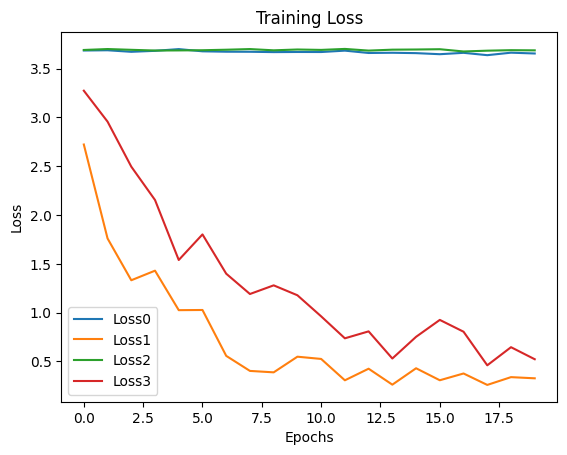

TypeError: 'type' object is not subscriptable

In [54]:
#实例化模型
modelOrigin = OlivettiFacesNN().to(device)
modelBatchNorm = OlivettiFacesNNBatchN().to(device)
modelDropout = OlivettiFacesNNDrop().to(device)
modelBatchDrop = OlivettiFacesNNBatchNDrop().to(device)
# 训练
hist_list = [model.train_iter(epochs, train_loader, LR) for model in [modelOrigin,modelBatchNorm,modelDropout,modelBatchDrop]]
# 绘制训练曲线图
draw_train_hist(hist_list)

In [60]:
# 测试
acc_list = [(model.test_accOrigin(test_loader),text) for model ,text in zip( [modelOrigin,modelBatchNorm,modelDropout,modelBatchDrop],["modelOrigin","modelBatchNorm","modelDropout","modelBatchDrop"])]
for acc , text in acc_list:
    print(f"{text} Accuracy:  {acc}%")

modelOrigin Accuracy:  15.0%
modelBatchNorm Accuracy:  96.25%
modelDropout Accuracy:  2.5%
modelBatchDrop Accuracy:  91.25%
